In [1]:
import json

def load_ndjson(path):
    data = []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                data.append(json.loads(line))
    return data

# Load all splits
train_1 = load_ndjson("train00.json")
train_2 = load_ndjson("train01.json")
train_3 = load_ndjson("train02.json")
train_4 = load_ndjson("train03.json")
dev_data = load_ndjson("valid.json")
test_data = load_ndjson("test.json")

# Merge train splits
train_data = train_1 + train_2 + train_3 + train_4
print(f"Train sentences: {len(train_data)}  | Dev: {len(dev_data)} | Test: {len(test_data)}")

Train sentences: 59924  | Dev: 8528 | Test: 8262


In [2]:
# Optional: quick alignment check
def check_alignment(data, name):
    bad = sum(1 for e in data if len(e["tokens"]) != len(e["tags"]))
    print(f"{name}: {bad} misaligned sentences")

check_alignment(train_data, "train")
check_alignment(dev_data,   "dev")
check_alignment(test_data,  "test")

train: 0 misaligned sentences
dev: 0 misaligned sentences
test: 0 misaligned sentences


#  Load Tag Dictionary and Convert Sentences


In [3]:
# Load the label dictionary (tag string -> index) and build inverse mapping
with open("label.json", encoding="utf-8") as f:
    tag2idx = json.load(f)


tag2idx['<PAD_TAG>'] = len(tag2idx)
idx2tag = {i: t for t, i in tag2idx.items()}
PAD_TAG_IDX = tag2idx['<PAD_TAG>']


# Convert dataset entries into (word, tag_str) pairs per sentence
def to_pairs(data):
    sents = []
    for e in data:
        tokens = e["tokens"]
        tags_i = e["tags"]
        tags_s = [idx2tag[int(t)] for t in tags_i]
        sents.append(list(zip(tokens, tags_s)))
    return sents

train_sents = to_pairs(train_data)
dev_sents   = to_pairs(dev_data)
test_sents  = to_pairs(test_data)
print(" Sample sentence:", train_sents[0])

 Sample sentence: [('People', 'O'), ('start', 'O'), ('their', 'O'), ('own', 'O'), ('businesses', 'O'), ('for', 'O'), ('many', 'O'), ('reasons', 'O'), ('.', 'O')]


# Build Word Vocabulary


In [4]:
# Step 1: Initialize vocabulary with special tokens
word2idx = {
    '<PAD>': 0,   # for padding
    '<UNK>': 1    # for unknown words
}

# Step 2: Loop through all training sentences and collect lowercase words
for sent in train_sents:
    for word, _ in sent:
        word_lower = word.lower()
        if word_lower not in word2idx:
            word2idx[word_lower] = len(word2idx)

# Step 3: Create reverse mapping
idx2word = {i: w for w, i in word2idx.items()}

# Step 4: Print summary and sample
print(f"✅ Vocabulary size: {len(word2idx)}")
print("🔍 Sample vocabulary entries:")
for i, (word, idx) in enumerate(word2idx.items()):
    print(f"{idx:4} → {word}")
    if i >= 30: break  # print first 30 entries only


✅ Vocabulary size: 36100
🔍 Sample vocabulary entries:
   0 → <PAD>
   1 → <UNK>
   2 → people
   3 → start
   4 → their
   5 → own
   6 → businesses
   7 → for
   8 → many
   9 → reasons
  10 → .
  11 → but
  12 → a
  13 → chance
  14 → to
  15 → fill
  16 → out
  17 → sales
  18 → -
  19 → tax
  20 → records
  21 → is
  22 → rarely
  23 → one
  24 → of
  25 → them
  26 → red
  27 → tape
  28 → the
  29 → bugaboo
  30 → small


# Encode and Pad Sequences

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

PAD_WORD_IDX = word2idx['<PAD>']
PAD_TAG_IDX  = tag2idx['<PAD_TAG>']

def encode_and_pad(sents, max_len=None):
    X, y = [], []
    for sent in sents:
        word_ids = [word2idx.get(w.lower(), word2idx['<UNK>']) for w, _ in sent]
        tag_ids  = [tag2idx[t] for _, t in sent]
        X.append(word_ids)
        y.append(tag_ids)

    if max_len is None:
        max_len = max(len(seq) for seq in X)

    X_pad = pad_sequences(X, maxlen=max_len, padding='post', value=PAD_WORD_IDX)
    y_pad = pad_sequences(y, maxlen=max_len, padding='post', value=PAD_TAG_IDX)
    mask  = (y_pad != PAD_TAG_IDX).astype('float32')
    y_pad = y_pad.reshape((-1, max_len, 1)).astype('int32')

    # Print a few examples
    for i in range(min(1, len(sents))):
        print(f"\n🔹 Original sentence {i+1}: {sents[i]}")
        print("   Encoded words:", X[i])
        print("   Encoded tags :", y[i])
        print("   After padding (words):", X_pad[i])
        print("   After padding (tags) :", y_pad[i].flatten())
        print("   Mask:", mask[i])

    return X_pad, y_pad, mask, max_len


X_train, y_train, w_train, max_len = encode_and_pad(train_sents)
X_dev,   y_dev,   w_dev,   _       = encode_and_pad(dev_sents,  max_len)
X_test,  y_test,  w_test,  _       = encode_and_pad(test_sents, max_len)


🔹 Original sentence 1: [('People', 'O'), ('start', 'O'), ('their', 'O'), ('own', 'O'), ('businesses', 'O'), ('for', 'O'), ('many', 'O'), ('reasons', 'O'), ('.', 'O')]
   Encoded words: [2, 3, 4, 5, 6, 7, 8, 9, 10]
   Encoded tags : [0, 0, 0, 0, 0, 0, 0, 0, 0]
   After padding (words): [ 2  3  4  5  6  7  8  9 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
   After padding (tags) : [ 0  0  0  0  0  0  0  0  0 37 37 37 37 37 37 3

# Step 5: Build BiGRU Model


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, TimeDistributed, Dense, Dropout
import tensorflow.keras.backend as K

def masked_accuracy(y_true, y_pred):
    y_true = K.cast(K.squeeze(y_true, axis=-1), 'int32')
    y_pred = K.cast(K.argmax(y_pred, axis=-1), 'int32')
    mask = K.cast(K.not_equal(y_true, PAD_TAG_IDX), 'float32')
    matches = K.cast(K.equal(y_true, y_pred), 'float32')
    return K.sum(matches * mask) / K.sum(mask)

model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=128, input_length=max_len),
    Bidirectional(GRU(256, return_sequences=True)),
    Dropout(0.4),
    TimeDistributed(Dense(len(tag2idx), activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[masked_accuracy])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early   = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

model.fit(
    X_train, y_train,
    sample_weight=w_train,
    validation_data=(X_dev, y_dev, w_dev),
    epochs=15,
    batch_size=64,
    callbacks=[early, plateau]
)

Epoch 1/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 130s 122ms/step - loss: 0.0543 - masked_accuracy: 0.8871 - val_loss: 0.0177 - val_masked_accuracy: 0.9500 - learning_rate: 0.0010
Epoch 2/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 111s 119ms/step - loss: 0.0126 - masked_accuracy: 0.9602 - val_loss: 0.0152 - val_masked_accuracy: 0.9559 - learning_rate: 0.0010
Epoch 3/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 121s 129ms/step - loss: 0.0078 - masked_accuracy: 0.9735 - val_loss: 0.0159 - val_masked_accuracy: 0.9555 - learning_rate: 0.0010
Epoch 4/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 127s 136ms/step - loss: 0.0059 - masked_accuracy: 0.9796 - val_loss: 0.0165 - val_masked_accuracy: 0.9551 - learning_rate: 0.0010
Epoch 5/15
937/937 ━━━━━━━━━━━━━━━━━━━━ 142s 136ms/step - loss: 0.0040 - masked_accuracy: 0.9858 - val_loss: 0.0184 - val_masked_accuracy: 0.9557 - learning_rate: 5.0000e-04


In [8]:
import numpy as np

def evaluate_dev_accuracy(model, X_dev, y_dev, w_dev, idx2tag):
    # Predict tag probabilities
    y_pred_probs = model.predict(X_dev)
    y_pred_ids = np.argmax(y_pred_probs, axis=-1)

    # Flatten predictions and true labels, using the mask
    y_true_flat, y_pred_flat = [], []
    for true_seq, pred_seq, mask_seq in zip(y_dev.squeeze(-1), y_pred_ids, w_dev):
        for t, p, m in zip(true_seq, pred_seq, mask_seq):
            if m == 1:  # only count non-padding
                y_true_flat.append(t)
                y_pred_flat.append(p)

    # Compute accuracy
    correct = sum(t == p for t, p in zip(y_true_flat, y_pred_flat))
    total = len(y_true_flat)
    accuracy = correct / total if total > 0 else 0.0

    print(f" Dev accuracy: {accuracy:.4f} ({correct}/{total} correct tags)")
    return accuracy

In [9]:
evaluate_dev_accuracy(model, X_dev, y_dev, w_dev, idx2tag)


267/267 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step
 Dev accuracy: 0.9525 (140708/147718 correct tags)


np.float64(0.9525447135758676)

#  Step 7: Evaluate on valid Set


In [10]:
y_pred = model.predict(X_test)
y_pred_ids = np.argmax(y_pred, axis=-1)

y_true_flat, y_pred_flat = [], []
for true_seq, pred_seq, w_seq in zip(y_test.squeeze(-1), y_pred_ids, w_test):
    for t, p, w in zip(true_seq, pred_seq, w_seq):
        if w == 1:
            y_true_flat.append(t)
            y_pred_flat.append(p)

y_true_tags = [idx2tag[i] for i in y_true_flat]
y_pred_tags = [idx2tag[i] for i in y_pred_flat]

from sklearn.metrics import classification_report
print("Final test evaluation:")
print(classification_report(y_true_tags, y_pred_tags, digits=3))

259/259 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
Final test evaluation:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

   B-CARDINAL      0.769     0.729     0.749       935
       B-DATE      0.817     0.790     0.803      1602
      B-EVENT      0.533     0.254     0.344        63
        B-FAC      0.562     0.133     0.216       135
        B-GPE      0.937     0.865     0.899      2240
   B-LANGUAGE      0.875     0.318     0.467        22
        B-LAW      0.545     0.150     0.235        40
        B-LOC      0.538     0.520     0.528       179
      B-MONEY      0.825     0.767     0.795       313
       B-NORP      0.833     0.864     0.848       841
    B-ORDINAL      0.739     0.785     0.761       195
        B-ORG      0.818     0.577     0.677      1795
    B-PERCENT      0.893     0.908     0.901       349
     B-PERSON      0.890     0.805     0.845      1988
    B-PRODUCT      0.886     0.408     0.559        76
   B-QUANTITY      0.743     0.714     0.728       105
       B-TIME      0.583     0.481     0.527       212
B-WORK_OF

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X, y, w, idx2tag, tag_subset=None, sample_size=100):
    # Predict tag probabilities
    y_pred_probs = model.predict(X[:sample_size])
    y_pred_ids = np.argmax(y_pred_probs, axis=-1)

    # Flatten predictions and true labels using mask
    y_true_flat, y_pred_flat = [], []
    for true_seq, pred_seq, mask_seq in zip(y[:sample_size].squeeze(-1), y_pred_ids, w[:sample_size]):
        for t, p, m in zip(true_seq, pred_seq, mask_seq):
            if m == 1:
                y_true_flat.append(t)
                y_pred_flat.append(p)

    # Convert to tag names
    y_true_tags = [idx2tag[i] for i in y_true_flat]
    y_pred_tags = [idx2tag[i] for i in y_pred_flat]

    # Optional: filter to specific tags
    if tag_subset:
        labels = tag_subset
    else:
        labels = sorted(set(y_true_tags + y_pred_tags))

    # Compute confusion matrix
    cm = confusion_matrix(y_true_tags, y_pred_tags, labels=labels)

    # Plot with larger figure size
    fig, ax = plt.subplots(figsize=(12, 10))  # Adjust size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=True)
    plt.title("Confusion Matrix (NER Tags)", fontsize=16)
    plt.tight_layout()
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


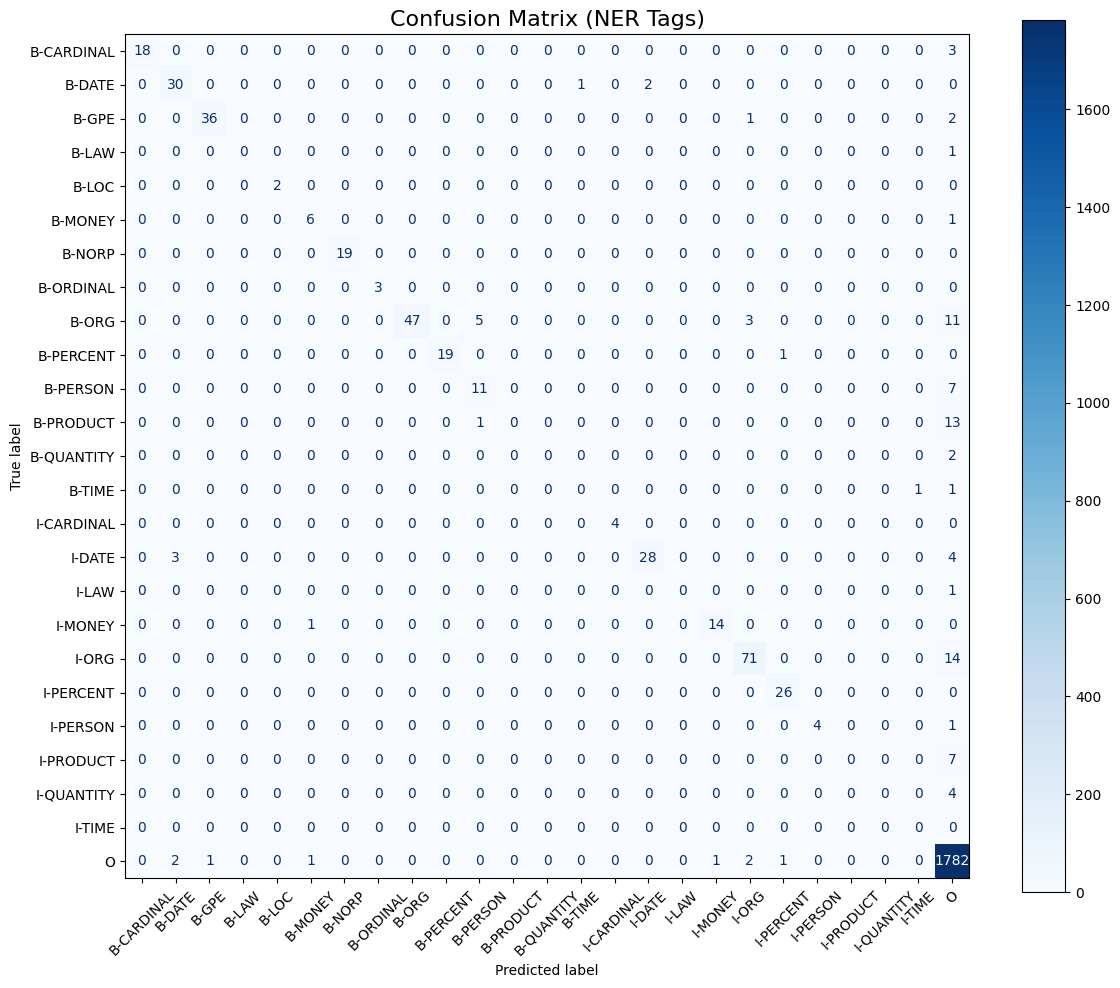

In [12]:
# Plot confusion matrix using first 100 test samples
plot_confusion_matrix(model, X_test, y_test, w_test, idx2tag, sample_size=100)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


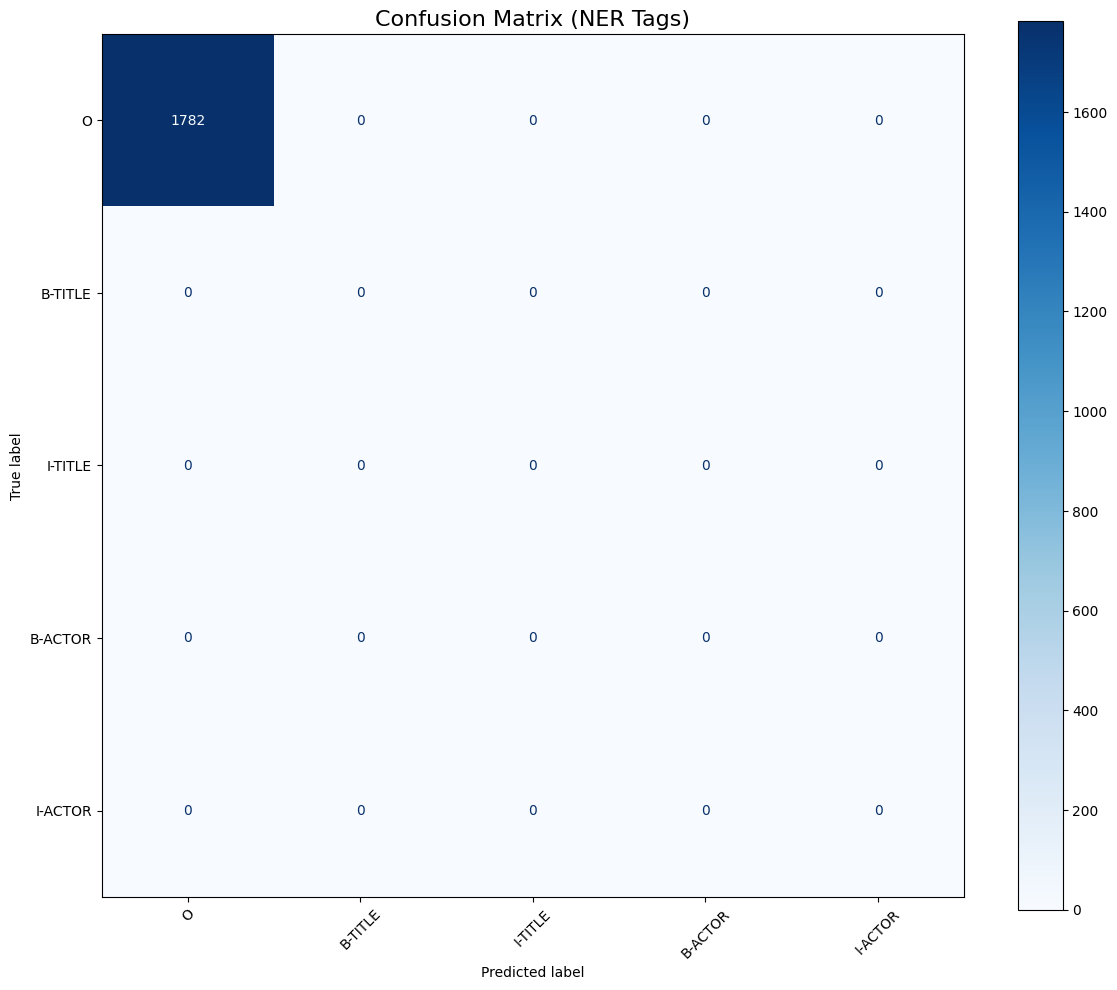

In [13]:
plot_confusion_matrix(model, X_test, y_test, w_test, idx2tag, tag_subset=["O", "B-TITLE", "I-TITLE", "B-ACTOR", "I-ACTOR"])

# manuall test

In [48]:
manual_sent = [("John", "O"), ("played", "O"), ("Batman", "O"), ("in", "O"), ("The", "O"), ("Dark", "O"), ("Knight", "O")]

In [49]:
def encode_manual_sentence(sent, max_len):
    word_ids = [word2idx.get(w.lower(), word2idx['<UNK>']) for w, _ in sent]
    X_pad = pad_sequences([word_ids], maxlen=max_len, padding='post', value=PAD_WORD_IDX)
    return X_pad

In [50]:
X_manual = encode_manual_sentence(manual_sent, max_len)
y_pred_probs = model.predict(X_manual)
y_pred_ids = np.argmax(y_pred_probs, axis=-1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [51]:
predicted_tags = [idx2tag[i] for i in y_pred_ids[:len(manual_sent)]]
for (word, _), tag in zip(manual_sent, predicted_tags):
    print(f"{word:10} → {tag}")

John       → B-PERSON
played     → O
Batman     → O
in         → O
The        → O
Dark       → O
Knight     → O


# BIGRO ON THE MOVIE DATASET

In [39]:
import json

# Load the JSON file
with open("movies.json", "r", encoding="utf-8") as f:
    script_data = json.load(f)

In [57]:
import re

def is_valid_line(line):
    line = line.strip()
    return not line.isupper() and len(line.split()) > 3

def simple_tokenize(text):
    return re.findall(r"\w[\w']*", text)

script_sentences = []
for entry in script_data:
    if isinstance(entry, dict) and "Script" in entry:
        lines = entry["Script"].splitlines()
        for line in lines:
            if is_valid_line(line):
                tokens = simple_tokenize(line)
                if tokens:
                    script_sentences.append(tokens)

In [58]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
MAX_LEN = 128  # match your training setup

def encode_sentence(sent):
    # Dummy tags for inference
    dummy_tags = ["O"] * len(sent)
    tag_ids = [tag2idx[t] for t in dummy_tags]

    enc = tokenizer(sent,
                    is_split_into_words=True,
                    truncation=True,
                    padding="max_length",
                    max_length=MAX_LEN,
                    return_tensors="pt")

    word_ids = enc.word_ids()
    aligned_labels = []
    prev_word = None
    for i, word_id in enumerate(word_ids):
        if word_id is None:
            aligned_labels.append(-100)
        elif word_id != prev_word:
            aligned_labels.append(tag_ids[word_id])
        else:
            aligned_labels.append(-100)
        prev_word = word_id

    enc["labels"] = aligned_labels
    return enc

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [67]:
for i, tokens in enumerate(script_sentences[:5]):
    enc = encode_sentence(tokens)  # returns dict with input_ids, attention_mask, labels

    input_ids = enc["input_ids"]  # TensorFlow tensor
    attention_mask = enc["attention_mask"]

    # Run model
    logits = model(input_ids)  # ✅ TensorFlow model call

    # Convert logits to predicted tag indices
    pred_ids = np.argmax(logits.numpy(), axis=-1)[0]

    word_ids = enc.word_ids()
    prev_word = None
    print(f"Sentence {i+1}:")
    for idx, word_id in enumerate(word_ids):
        if word_id is None or word_id == prev_word:
            continue
        word = tokens[word_id]
        tag = idx2tag[pred_ids[idx]]
        print(f"{word:<15} ➔ {tag}")
        prev_word = word_id
    print("=" * 50)

Sentence 1:
We're           ➔ O
watching        ➔ O
a               ➔ O
pair            ➔ O
of              ➔ O
hands           ➔ O
arrange         ➔ O
white           ➔ B-ORG
sugar           ➔ O
packets         ➔ O
Sentence 2:
blue            ➔ O
Equal           ➔ B-PERSON
packets         ➔ O
and             ➔ B-PERSON
pink            ➔ I-PERSON
Sweet           ➔ I-PERSON
and             ➔ B-PERSON
Low             ➔ O
into            ➔ O
small           ➔ O
Sentence 3:
containers      ➔ O
With            ➔ O
precision       ➔ B-PERSON
and             ➔ I-PERSON
lightning       ➔ O
speed           ➔ O
the             ➔ B-DATE
mixed           ➔ B-DATE
up              ➔ I-DATE
Sentence 4:
colors          ➔ B-PERSON
and             ➔ B-PERSON
crumpled        ➔ I-PERSON
packets         ➔ O
are             ➔ O
transformed     ➔ O
into            ➔ O
neat            ➔ O
little          ➔ O
Sentence 5:
color           ➔ O
coded           ➔ O
rows            ➔ O
Wait            ➔ B-DATE
this  